Import dependencies

In [3]:
from model.layers import GraphSpectralFilterLayer, AnalysisFilter
from model.spectral_filter import Graph
import torch
import torch.nn.functional as F
from torch import nn
from random import seed as rseed
from numpy.random import seed as nseed
from citation import get_planetoid_dataset, random_planetoid_splits, run
from citation.train_eval import evaluate
import numpy as np


Define hyperparameters

In [4]:
dataset_name = 'Citeseer'

random_splits = False
runs = 1
epochs =400
alpha = 0.4325176513738335
seed =729
lr =0.0001502755734819816
weight_decay =9.70164175612743e-05
patience=100
hidden=83
heads =19
dropout=0.6760251172015357
normalize_features =True
pre_training = False
cuda = False
chebyshev_order =17
edge_dropout =0
node_feature_dropout =0
filter ='analysis'

rseed(seed)
nseed(seed)
torch.manual_seed(seed)

cuda = cuda and torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
def get_correctly_predicted_node_idx(net, key):
    net.eval()
    with torch.no_grad():
        logits  = net(dataset[0])[0]
    mask = dataset[0]['{}_mask'.format(key)]
    pred = logits[mask].max(1)[1]
    return { *pred.eq(dataset[0].y[mask]).nonzero().view(-1).tolist() }

In [5]:
def matching_labels_distribution(nodes_set):
    hop_1_matching_percent = []
    hop_2_matching_percent = []
    hop_3_matching_percent = []
    for n in nodes_set:
        hop_1_neighbours = list(nx.ego_graph(G, n.item(), 1).nodes())
        hop_2_neighbours = list(nx.ego_graph(G, n.item(), 2).nodes())
        hop_3_neighbours = list(nx.ego_graph(G, n.item(), 3).nodes())
        node_label = dataset[0].y[n]
        hop_1_labels = dataset[0].y[hop_1_neighbours]
        hop_2_labels = dataset[0].y[hop_2_neighbours]
        hop_3_labels = dataset[0].y[hop_3_neighbours]
        matching_1_labels = node_label == hop_1_labels
        matching_2_labels = node_label == hop_2_labels
        matching_3_labels = node_label == hop_3_labels
        hop_1_matching_percent.append(matching_1_labels.float().sum()/matching_1_labels.shape[0])
        hop_2_matching_percent.append(matching_2_labels.float().sum()/matching_2_labels.shape[0])
        hop_3_matching_percent.append(matching_3_labels.float().sum()/matching_3_labels.shape[0])


    print('matching labels in 1st hop:', torch.tensor(hop_1_matching_percent).mean())
    print('matching labels in 2st hop:', torch.tensor(hop_2_matching_percent).mean())
    print('matching labels in 3rd hop:', torch.tensor(hop_3_matching_percent).mean())
    plt.figure(figsize=(15,3))
    plt.subplot(1, 3, 1)
    plt.hist(hop_1_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    plt.subplot(1, 3, 2)
    plt.hist(hop_2_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    plt.subplot(1, 3, 3)
    plt.hist(hop_2_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)


Define model

In [6]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        data = dataset[0]
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter,
                                                 pre_training=pre_training, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, chebyshev_order=chebyshev_order)
        # self.mlp = nn.Sequential(nn.Linear(hidden * heads, 128),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(128, 64),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(64, 32),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(32, dataset.num_classes),
        #                             nn.ReLU(inplace=True))

        # self.W = torch.zeros(hidden * heads, dataset.num_classes)

        self.synthesis = GraphSpectralFilterLayer(self.G, hidden * heads, dataset.num_classes, filter=filter,
                                                  device='cuda' if cuda else 'cpu', dropout=dropout,
                                                  out_channels=1, alpha=alpha, pre_training=False,
                                                  chebyshev_order=chebyshev_order)

    def reset_parameters(self):
        self.analysis.reset_parameters()
        # torch.nn.init.xavier_uniform_(self.W.data, gain=1.414)
        # for layer in self.mlp:
        #     if hasattr(layer, 'reset_parameters'):
        #         layer.reset_parameters()
        self.synthesis.reset_parameters()

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_2 = self.synthesis(x)
        x = F.elu(x)
        # x = F.elu(x.mm(self.W))
        # x = self.mlp(x)
        return F.log_softmax(x, dim=1), attentions_1, attentions_2


dataset = get_planetoid_dataset(dataset_name, normalize_features, edge_dropout=edge_dropout,
                                node_feature_dropout=node_feature_dropout)
if cuda:
    dataset[0].to('cuda')

# permute_masks = random_planetoid_splits if random_splits else None
# run(dataset, Net(dataset), runs, epochs, lr, weight_decay,
#     early_stopping, permute_masks)

Load trained model and evaluate

In [7]:
model = Net(dataset)
model.load_state_dict(torch.load('./model/best_{}_gpu.pkl'.format(dataset_name),  map_location={'cuda:0': 'cpu'}))
filter_kernel = model.analysis.filter_kernel

model_correct_indices = get_correctly_predicted_node_idx(model, 'test')
evaluate(model, dataset[0])

{'train_loss': 0.354785293340683,
 'train_acc': 0.9178981937602627,
 'val_loss': 0.6721668243408203,
 'val_acc': 0.788,
 'test_loss': 0.6676501631736755,
 'test_acc': 0.809,
 'f1_score': 0.8656447249774571}

Obtain attention weights in layer 1 and 2

In [8]:
with torch.no_grad():
    _, att1, att2 = model(dataset[0])


Build NetworkX Graph

In [9]:
from networkx import Graph
import networkx as nx
from scipy.sparse import coo_matrix
import numpy as np

# Build graph
adj = coo_matrix(
    (np.ones(dataset[0].num_edges),
    (dataset[0].edge_index[0].numpy(), dataset[0].edge_index[1].numpy())),
    shape=(dataset[0].num_nodes, dataset[0].num_nodes))
G = Graph(adj)


In [14]:
from matplotlib import pyplot as plt
def plot_filter_banks(idx=list(range(heads)), kernel=model.analysis.filter._kernel, ax=None):
    x = torch.linspace(0, 2, 100)
    if not ax:
        plt.figure()
        plt.plot(x, kernel(x).detach()[:, idx])
        plt.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])
        plt.show()
    else:
        ax.plot(x, kernel(x).detach()[:, idx])
        ax.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])

Plot filterbanks in layer 1 and 2

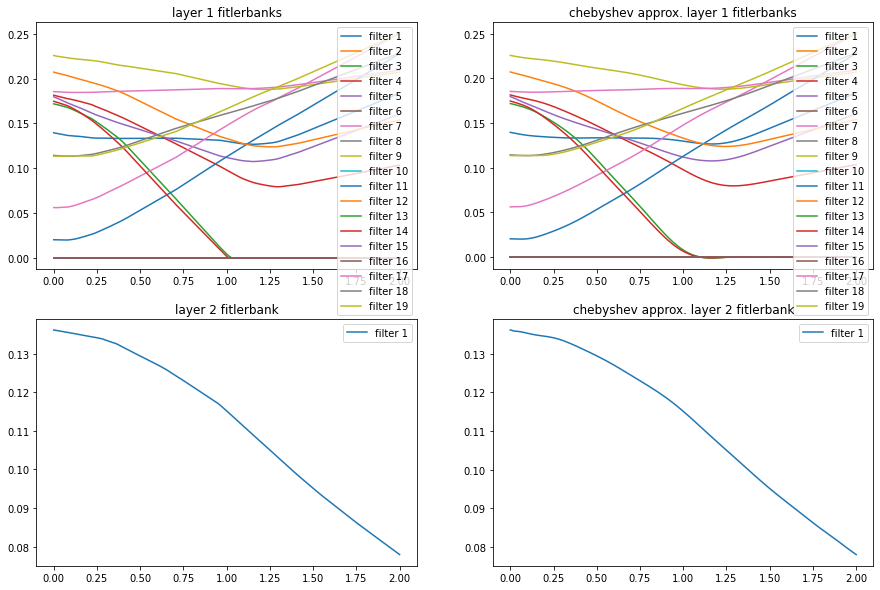

In [22]:
plt.figure(figsize=(15,10))
ax1 = plt.subplot(2, 2, 1)
ax1.set_title('layer 1 fitlerbanks')
plot_filter_banks(kernel=model.analysis.filter._kernel, ax=ax1)
ax2 = plt.subplot(2, 2, 2)
ax2.set_title('chebyshev approx. layer 1 fitlerbanks')
plot_filter_banks(kernel=model.analysis.filter.cheby_eval, ax=ax2)
ax3 = plt.subplot(2, 2, 3)
ax3.set_title('layer 2 fitlerbank')
plot_filter_banks(idx=[0], kernel=model.synthesis.filter._kernel, ax=ax3)
ax4 = plt.subplot(2, 2, 4)
ax4.set_title('chebyshev approx. layer 2 fitlerbank')
plot_filter_banks(idx=[0], kernel=model.synthesis.filter.cheby_eval, ax=ax4)

### Frequency cutoff analysis

In [23]:
# Cut frequency bands abruptly
class CutOff(nn.Module):
    def __init__(self, kernel, min_val = 0, max_val = 2):
        super(CutOff, self).__init__()
        self.min = min_val
        self.max = max_val
        self.kernel = kernel

    def reset_parameters(self):
        pass

    def forward(self, x):
        h = torch.where(x.view(-1,1).repeat(1, heads) < self.min, torch.zeros(x.shape[0], heads), self.kernel(x))
        h = torch.where(x.view(-1,1).repeat(1, heads) > self.max, torch.zeros(x.shape[0], heads), h)
        return h

Evaluate low pass cutoff

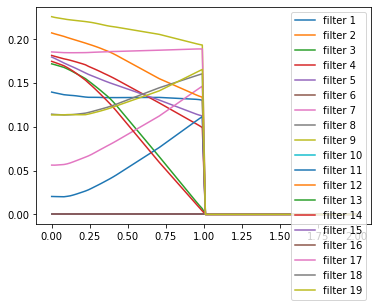

{'train_loss': 0.42847517132759094, 'train_acc': 0.8620689655172413, 'val_loss': 0.666549026966095, 'val_acc': 0.792, 'test_loss': 0.6691321730613708, 'test_acc': 0.803, 'f1_score': 0.8337841899609257}


In [139]:
threshold = 1
model.analysis.filter_kernel = CutOff(max_val=threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(max_val=threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

low_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test')
with torch.no_grad():
    _, low_att1, low_att2 = model(dataset[0])

Evaluate high pass cutoff

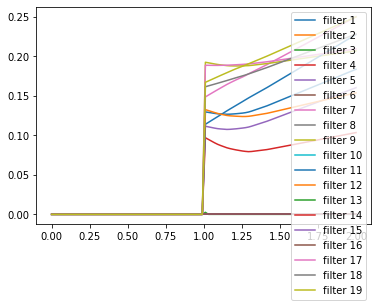

{'train_loss': 0.5402587652206421, 'train_acc': 0.8139025725232621, 'val_loss': 0.7292685508728027, 'val_acc': 0.762, 'test_loss': 0.7223657369613647, 'test_acc': 0.781, 'f1_score': 0.7962128043282236}


In [140]:
threshold = 1
model.analysis.filter_kernel = CutOff(min_val=threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(min_val=threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

high_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test')

with torch.no_grad():
    _, high_att1, high_att2 = model(dataset[0])

Evaluate band pass cutoff

In [61]:
# for threshold in torch.arange(0, 2, 1):
#     model.analysis.filter_kernel = CutOff(min_val=threshold, max_val=threshold+0.1, kernel=model.analysis.filter_kernel)
#     model.analysis.filter._kernel = CutOff(min_val=threshold,max_val=threshold+0.1, kernel=model.analysis.filter_kernel)
# #     plot_filter_banks(kernel=model.analysis.filter_kernel)
#     print(evaluate(model, dataset[0]))

#### Frequency analysis on cutoff

In [141]:
low_not_high_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(low_pass_correct_indices.difference(high_pass_correct_indices))]
high_not_low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.difference(low_pass_correct_indices))]
high_and_low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.intersection(low_pass_correct_indices))]


print('Number of node classified correctly by low-pass filters but not by high-pass filters:', len(low_not_high_correct_nodes))
print('Number of node classified correctly by high-pass filters but not by low-pass filters:', len(high_not_low_correct_nodes))
print('Number of node classified correctly by both high-pass and low-pass filters:', len(high_and_low_correct_nodes))

Number of node classified correctly by low-pass filters but not by high-pass filters: 35
Number of node classified correctly by high-pass filters but not by low-pass filters: 13
Number of node classified correctly by both high-pass and low-pass filters: 768


Neighbour distribution of nodes classified correct by high-pass but not low pass

matching labels in 1st hop: tensor(0.5394)
matching labels in 2st hop: tensor(0.5381)
matching labels in 3rd hop: tensor(0.5213)


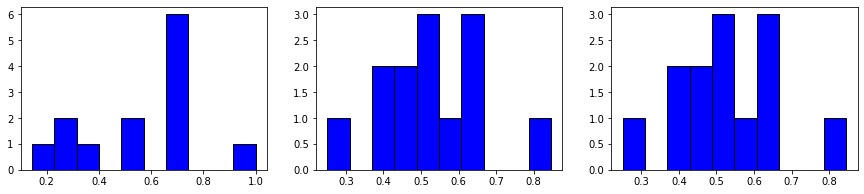

In [142]:
matching_labels_distribution(high_not_low_correct_nodes)

matching labels in 1st hop: tensor(0.6664)
matching labels in 2st hop: tensor(0.4546)
matching labels in 3rd hop: tensor(0.3675)


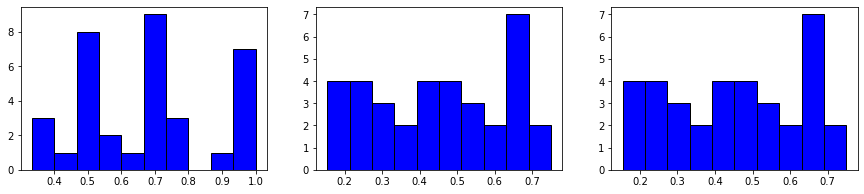

In [143]:
matching_labels_distribution(low_not_high_correct_nodes)

matching labels in 1st hop: tensor(0.9184)
matching labels in 2st hop: tensor(0.8733)
matching labels in 3rd hop: tensor(0.8285)


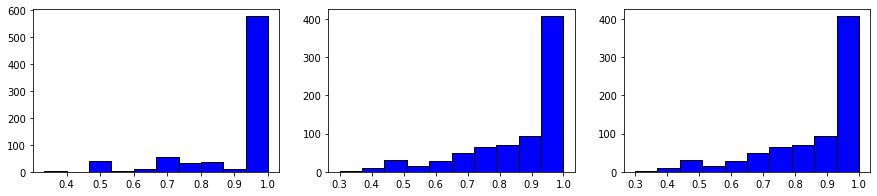

In [136]:
matching_labels_distribution(high_and_low_correct_nodes)

Draw attentions from high-pass filterbank(s)

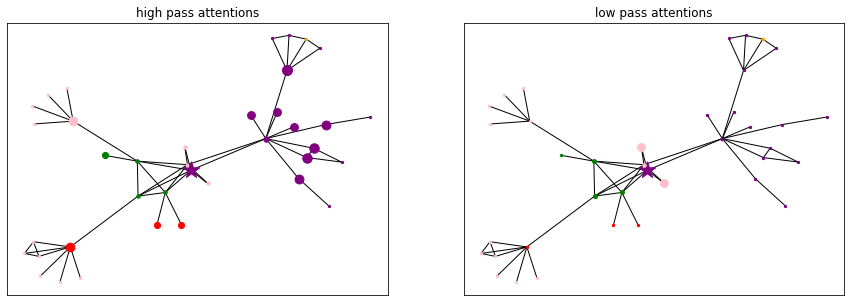

In [153]:
low_attentions = torch.stack(low_att1, 0).sum(0)
high_attentions = torch.stack(high_att1, 0).sum(0)

index = 0
node = high_not_low_correct_nodes[index].item()
# node = low_not_high_correct_nodes[2].item()

node_colors = {0: 'red', 1: 'orange', 2: 'purple', 3: 'lime', 4: 'pink', 5: 'green', 6: 'black'}
Gego = nx.ego_graph(G, node, 3)
nodePos = nx.layout.spring_layout(Gego)

plt.figure(figsize=(15,5))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high pass attentions')

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           ax=ax1,
                           nodelist=[n],
                           node_color=node_colors[dataset[0].y[n].item()],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else torch.exp(high_attentions[node, n]*4).clamp(max=300, min=5))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax1)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low pass attentions')

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           ax=ax2,
                           nodelist=[n],
                           node_color=node_colors[dataset[0].y[n].item()],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else torch.exp(low_attentions[node, n]*4).clamp(max=300, min=5))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax2)

plt.show()


Re-train model with cutoff

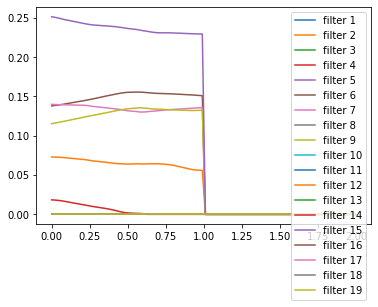

{'train_loss': 1.7917492389678955, 'train_acc': 0.16091954022988506, 'val_loss': 1.7917522192001343, 'val_acc': 0.138, 'test_loss': 1.7917500734329224, 'test_acc': 0.16, 'f1_score': 0.15719867748722574}
{'train_loss': 1.7863214015960693, 'train_acc': 0.4455391351943076, 'val_loss': 1.786186695098877, 'val_acc': 0.448, 'test_loss': 1.7862392663955688, 'test_acc': 0.43, 'f1_score': 0.4412383528704539, 'epoch': 10}
{'train_loss': 1.780252456665039, 'train_acc': 0.5977011494252874, 'val_loss': 1.7803117036819458, 'val_acc': 0.584, 'test_loss': 1.780470848083496, 'test_acc': 0.579, 'f1_score': 0.5900210399759543, 'epoch': 20}
{'train_loss': 1.7734917402267456, 'train_acc': 0.6524356869184456, 'val_loss': 1.7737419605255127, 'val_acc': 0.648, 'test_loss': 1.7740339040756226, 'test_acc': 0.639, 'f1_score': 0.6477306883077848, 'epoch': 30}
{'train_loss': 1.7655634880065918, 'train_acc': 0.6830870279146142, 'val_loss': 1.7660198211669922, 'val_acc': 0.684, 'test_loss': 1.7664850950241089, 'test

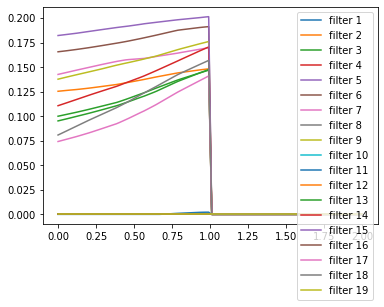

In [13]:
# Similar result as cutoff after training
# from citation import run
#
# model_cutoff = Net(dataset)
#
# max_cutoff=1
# cutoff_kernel = model_cutoff.analysis.filter_kernel
# model_cutoff.analysis.filter_kernel = CutOff(max_val=max_cutoff, kernel=cutoff_kernel)
# model_cutoff.analysis.filter._kernel = CutOff(max_val=max_cutoff, kernel=cutoff_kernel)
#
# plot_filter_banks(kernel=model_cutoff.analysis.filter_kernel)
# print(evaluate(model_cutoff, dataset[0]))
#
# run(dataset, model_cutoff, runs, epochs, lr, weight_decay, patience, None)
#
# plot_filter_banks(kernel=model_cutoff.analysis.filter_kernel)
# print(evaluate(model_cutoff, dataset[0]))



## Evaluate filterbanks

Define kernel to eliminate certain filterbanks

In [99]:
class Elimination(nn.Module):
    def __init__(self, zero_out_indices):
        super(Elimination, self).__init__()
        self.zero_out_indices = zero_out_indices

    def reset_parameters(self):
        pass

    def forward(self, x):
        x = filter_kernel(x)
        x[:, self.zero_out_indices] = torch.zeros(x.shape[0], len(self.zero_out_indices))
        return x

Evaluate each filter bank

In [87]:
all_indices = set(list(range(heads)))
for i in range(heads):
    zero_out_filters = list(all_indices.difference({i}))
    model.analysis.filter_kernel = Elimination(zero_out_filters)
    model.analysis.filter._kernel = Elimination(zero_out_filters)
    # plot_filter_banks(kernel=model.analysis.filter_kernel)
    print(evaluate(model, dataset[0]))

{'train_loss': 0.5136096477508545, 'train_acc': 0.8303229337712096, 'val_loss': 0.7006813883781433, 'val_acc': 0.78, 'test_loss': 0.7047087550163269, 'test_acc': 0.784, 'f1_score': 0.8088367899008114}
{'train_loss': 0.5372918248176575, 'train_acc': 0.8182813355227149, 'val_loss': 0.7087335586547852, 'val_acc': 0.776, 'test_loss': 0.7135993838310242, 'test_acc': 0.786, 'f1_score': 0.8022242260294559}
{'train_loss': 0.5342297554016113, 'train_acc': 0.8199233716475096, 'val_loss': 0.7055401802062988, 'val_acc': 0.78, 'test_loss': 0.7110466361045837, 'test_acc': 0.787, 'f1_score': 0.8040276525398257}
{'train_loss': 0.5146254301071167, 'train_acc': 0.8292282430213465, 'val_loss': 0.7008858919143677, 'val_acc': 0.78, 'test_loss': 0.7051369547843933, 'test_acc': 0.785, 'f1_score': 0.8085362188157499}
{'train_loss': 0.5135645270347595, 'train_acc': 0.8303229337712096, 'val_loss': 0.7005741000175476, 'val_acc': 0.78, 'test_loss': 0.7049381732940674, 'test_acc': 0.785, 'f1_score': 0.809137360985

Evaluate by eliminating only one filter bank

In [89]:
for i in range(heads):
    model.analysis.filter_kernel = Elimination([i])
    model.analysis.filter._kernel = Elimination([i])
    # plot_filter_banks(kernel=model.analysis.filter_kernel)
    print(evaluate(model, dataset[0]))


{'train_loss': 0.36696603894233704, 'train_acc': 0.9080459770114943, 'val_loss': 0.6703996658325195, 'val_acc': 0.786, 'test_loss': 0.6671916842460632, 'test_acc': 0.807, 'f1_score': 0.8593327321911632}
{'train_loss': 0.35478514432907104, 'train_acc': 0.9178981937602627, 'val_loss': 0.6721669435501099, 'val_acc': 0.788, 'test_loss': 0.6676502823829651, 'test_acc': 0.809, 'f1_score': 0.8656447249774571}
{'train_loss': 0.35604503750801086, 'train_acc': 0.9184455391351943, 'val_loss': 0.6730226278305054, 'val_acc': 0.786, 'test_loss': 0.6684480905532837, 'test_acc': 0.807, 'f1_score': 0.865043582807334}
{'train_loss': 0.3663264513015747, 'train_acc': 0.909688013136289, 'val_loss': 0.6705018281936646, 'val_acc': 0.786, 'test_loss': 0.6670718789100647, 'test_acc': 0.807, 'f1_score': 0.8602344454463481}
{'train_loss': 0.36702102422714233, 'train_acc': 0.9085933223864259, 'val_loss': 0.6704887747764587, 'val_acc': 0.786, 'test_loss': 0.6670812964439392, 'test_acc': 0.806, 'f1_score': 0.859332

Load GAT model

In [23]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self, dataset):
        super(GAT, self).__init__()
        self.conv1 = GATConv(
            dataset.num_features,
            8,
            heads=8,
            dropout=0.6)
        self.conv2 = GATConv(
            64,
            dataset.num_classes,
            heads=1,
            concat=False,
            dropout=0.6)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x, (edge_index_1, att_val_1) = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x, (edge_index_2, att_val_2) = self.conv2(x, edge_index, return_attention_weights=True)
        att1 = torch.zeros(data.num_nodes, data.num_nodes, 8)
        att2 = torch.zeros(data.num_nodes, data.num_nodes)
        att1[list(map(lambda x: torch.tensor(x), edge_index_1.tolist()))] = att_val_1
        att2[list(map(lambda x: torch.tensor(x), edge_index_2.tolist()))] = att_val_2.view(-1)
        return F.log_softmax(x, dim=1), att1, att2

gat = GAT(dataset)
gat.load_state_dict(torch.load('./model/best_{}_gat.pkl'.format(dataset_name)))
gat_correct_indices = get_correctly_predicted_node_idx(gat, 'test')

with torch.no_grad():
    _, gat_att1, gat_att2 = gat(dataset[0])
evaluate(gat, dataset[0])

{'train_loss': 0.8178199529647827,
 'train_acc': 0.8106185002736727,
 'val_loss': 0.8965532183647156,
 'val_acc': 0.81,
 'test_loss': 0.8940090537071228,
 'test_acc': 0.778,
 'f1_score': 0.8007213706041478}

Comparison with GAT

In [24]:
model_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices)]
gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(gat_correct_indices)]
model_not_gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices.difference(gat_correct_indices))]
model_and_gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices.intersection(gat_correct_indices))]
gat_not_model_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(gat_correct_indices.difference(model_correct_indices))]
gat_and_model_incorrect_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(set(dataset[0].y[dataset[0]['test_mask']].nonzero().view(-1).tolist()).difference(model_correct_indices).difference(gat_correct_indices))]
print('Number of node classified correctly by our model:', len(model_correct_nodes))
print('Number of node classified correctly by GAT:', len(gat_correct_nodes))
print('Number of node classified correctly by our model but not by GAT:', len(model_not_gat_correct_nodes))
print('Number of node classified correctly by both GAT and our model:', len(model_and_gat_correct_nodes))
print('Number of node classified correctly by GAT but not by our model:', len(gat_not_model_correct_nodes))
print('Number of node classified incorrectly by GAT and our model:', len(gat_and_model_incorrect_nodes))


Number of node classified correctly by our model: 809
Number of node classified correctly by GAT: 778
Number of node classified correctly by our model but not by GAT: 54
Number of node classified correctly by both GAT and our model: 755
Number of node classified correctly by GAT but not by our model: 23
Number of node classified incorrectly by GAT and our model: 123


In [25]:
gat_att1_sum = gat_att1.sum(dim=2)
model_att1_sum = torch.stack(att1).sum(dim=0)

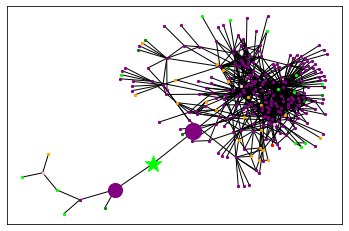

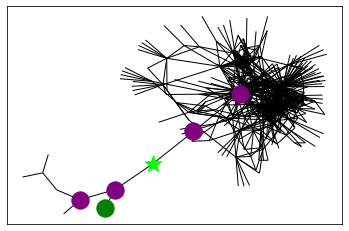

In [78]:
node = model_not_gat_correct_nodes[10].item()
Gego = nx.ego_graph(G, node, 5)
nodePos = nx.layout.spring_layout(Gego)
plt.figure()
for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=node_colors[dataset[0].y[n].item()],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else max(gat_att1_sum[node, n]*1e2, 5))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5)


plt.figure()
for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=node_colors[dataset[0].y[n].item()],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else max(model_att1_sum[node, n]*1e3, torch.tensor(0)).clamp_max(300))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5)



Label distribution of nodes classified correctly by our model

matching labels in 1st hop: tensor(0.8980)
matching labels in 2st hop: tensor(0.8459)
matching labels in 3rd hop: tensor(0.7984)


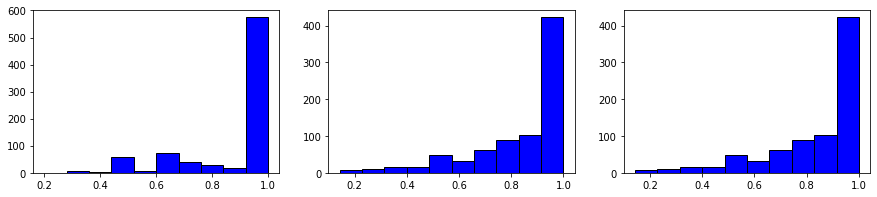

In [29]:
matching_labels_distribution(model_correct_nodes)

Label distribution of nodes classified correctly by GAT

matching labels in 1st hop: tensor(0.9083)
matching labels in 2st hop: tensor(0.8623)
matching labels in 3rd hop: tensor(0.8197)


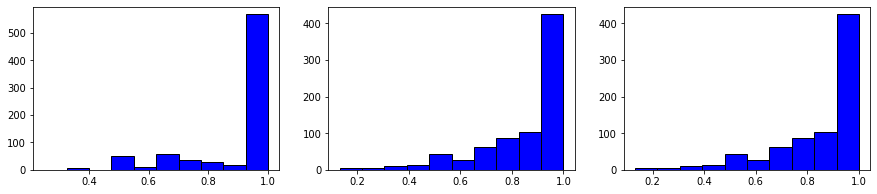

In [30]:
matching_labels_distribution(gat_correct_nodes)

Label distribution of nodes classified correctly by our model but not by GAT

matching labels in 1st hop: tensor(0.6716)
matching labels in 2st hop: tensor(0.5034)
matching labels in 3rd hop: tensor(0.4088)


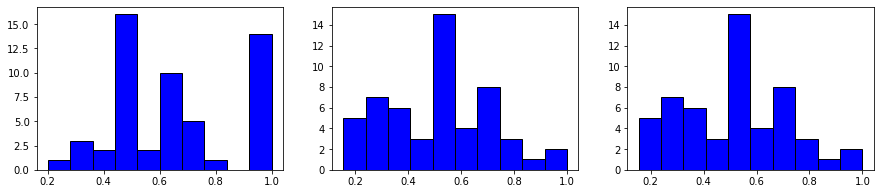

In [31]:
matching_labels_distribution(model_not_gat_correct_nodes)

Label distribution of nodes classified correctly our model and by GAT

matching labels in 1st hop: tensor(0.9142)
matching labels in 2st hop: tensor(0.8704)
matching labels in 3rd hop: tensor(0.8263)


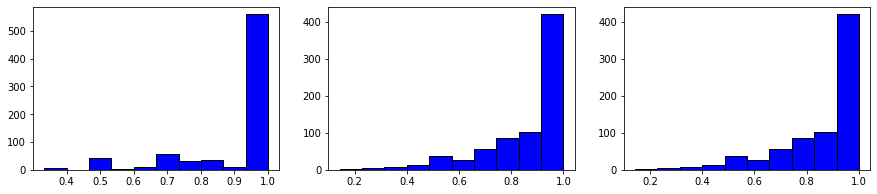

In [32]:
matching_labels_distribution(model_and_gat_correct_nodes)

Label distribution of nodes classified correctly GAT but not by our model

matching labels in 1st hop: tensor(0.7150)
matching labels in 2st hop: tensor(0.5972)
matching labels in 3rd hop: tensor(0.6046)


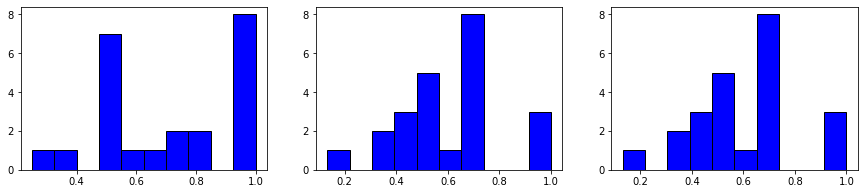

In [33]:
matching_labels_distribution(gat_not_model_correct_nodes)

Label distribution of nodes classified incorrectly by both GAT and our model

matching labels in 1st hop: tensor(0.5157)
matching labels in 2st hop: tensor(0.3686)
matching labels in 3rd hop: tensor(0.3230)


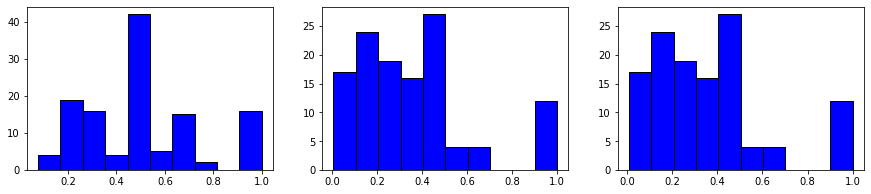

In [34]:
matching_labels_distribution(gat_and_model_incorrect_nodes)